<a href="https://colab.research.google.com/github/Anna4142/Gans/blob/main/ETHNICITYDETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1pAiCH8hxYF7UIbwm4AXNtN53SYb6Ntm0

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pAiCH8hxYF7UIbwm4AXNtN53SYb6Ntm0
To: /content/fairface.zip
100% 577M/577M [00:02<00:00, 223MB/s]


In [2]:
!unzip '/content/fairface.zip'

Streaming output truncated to the last 5000 lines.
  inflating: FairFace/val/55.jpg     
  inflating: FairFace/val/550.jpg    
  inflating: FairFace/val/5500.jpg   
  inflating: FairFace/val/5501.jpg   
  inflating: FairFace/val/5502.jpg   
  inflating: FairFace/val/5503.jpg   
  inflating: FairFace/val/5504.jpg   
  inflating: FairFace/val/5505.jpg   
  inflating: FairFace/val/5506.jpg   
  inflating: FairFace/val/5507.jpg   
  inflating: FairFace/val/5508.jpg   
  inflating: FairFace/val/5509.jpg   
  inflating: FairFace/val/551.jpg    
  inflating: FairFace/val/5510.jpg   
  inflating: FairFace/val/5511.jpg   
  inflating: FairFace/val/5512.jpg   
  inflating: FairFace/val/5513.jpg   
  inflating: FairFace/val/5514.jpg   
  inflating: FairFace/val/5515.jpg   
  inflating: FairFace/val/5516.jpg   
  inflating: FairFace/val/5517.jpg   
  inflating: FairFace/val/5518.jpg   
  inflating: FairFace/val/5519.jpg   
  inflating: FairFace/val/552.jpg    
  inflating: FairFace/val/5520.jpg   

##Download dependencies

In [3]:
import time
import pandas as pd
import numpy as np
from keras.utils import load_img, img_to_array
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import cv2

import scipy.io
import numpy as np

from datetime import datetime, timedelta
import time

import tensorflow as tf

import keras
import keras.utils as image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import cv2

import pandas as pd

In [4]:
tqdm.pandas()

##Download and prepare dataset

In [5]:
train_df = pd.read_csv("/content/FairFace/train_labels.csv")
test_df = pd.read_csv("/content/FairFace/val_labels.csv")

In [6]:
print("trainset consists of ",train_df.shape)
print("test set consist of ",test_df.shape)

trainset consists of  (86744, 5)
test set consist of  (10954, 5)


In [7]:
train_df = train_df[['file', 'race']]
test_df = test_df[['file', 'race']]

In [8]:
train_df['file'] = 'FairFace/'+train_df['file']
test_df['file'] = 'FairFace/'+test_df['file']

In [9]:
train_df.head()

,file,race
0,FairFace/train/1.jpg,East Asian
1,FairFace/train/2.jpg,Indian
2,FairFace/train/3.jpg,Black
3,FairFace/train/4.jpg,Indian
4,FairFace/train/5.jpg,Indian


In [10]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

,file
race,
Black,14.102416
East Asian,14.164668
Indian,14.201559
Latino_Hispanic,15.409711
Middle Eastern,10.624366
Southeast Asian,12.444665
White,19.052615


In [11]:
# There are 2 races as East and Southeast Asian. Group them in a single Asian Race
idx = train_df[(train_df['race'] == 'East Asian') | (train_df['race'] == 'Southeast Asian')].index
train_df.loc[idx, 'race'] = 'Asian'

idx = test_df[(test_df['race'] == 'East Asian') | (test_df['race'] == 'Southeast Asian')].index
test_df.loc[idx, 'race'] = 'Asian'

In [12]:
100*train_df.groupby(['race']).count()[['file']]/train_df.groupby(['race']).count()[['file']].sum()

,file
race,
Asian,26.609333
Black,14.102416
Indian,14.201559
Latino_Hispanic,15.409711
Middle Eastern,10.624366
White,19.052615


In [13]:
target_size = (224, 224)

def getImagePixels(file):
    #print(file)
    img = image.load_img(file, grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    return x

In [14]:
train_label = train_df[['race']]
test_label = test_df[['race']]

In [15]:
races = train_df['race'].unique()

In [16]:
for j in range(len(races)): #label encoding
    current_race = races[j]
    print("replacing ",current_race," to ", j+1)
    train_label['race'] = train_label['race'].replace(current_race, str(j+1))
    test_label['race'] = test_label['race'].replace(current_race, str(j+1))

train_label = train_label.astype({'race': 'int32'})
test_label = test_label.astype({'race': 'int32'})

replacing  Asian  to  1
replacing  Indian  to  2
replacing  Black  to  3
replacing  White  to  4
replacing  Middle Eastern  to  5
replacing  Latino_Hispanic  to  6


<ipython-input-16-8c1856772b82>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_label['race'] = train_label['race'].replace(current_race, str(j+1))
<ipython-input-16-8c1856772b82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_label['race'] = test_label['race'].replace(current_race, str(j+1))


##Load from the best model

In [17]:
!gdown --id 1-05mpXeMNYLQaCoFO1XEUnny_3CIYD4z
!gdown --id 1Ibkf2QUU7RFkux9VRBsjvQYwKakW1165

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-05mpXeMNYLQaCoFO1XEUnny_3CIYD4z
To: /content/race_model_weights.h5
100% 537M/537M [00:02<00:00, 195MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ibkf2QUU7RFkux9VRBsjvQYwKakW1165
To: /content/race_model.hdf5
100% 1.49G/1.49G [00:05<00:00, 275MB/s]


In [18]:
# load json and create model
from keras.models import load_model
race_model = load_model('/content/race_model.hdf5')
# load weights into new model
race_model.load_weights("/content/race_model_weights.h5")
print("Loaded model from disk")

Loaded model from disk


##Make your own predictions

In [19]:
!gdown --id 1TbzROGflBxOLc_Yc4D7T1cZUA74RJSCU

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1TbzROGflBxOLc_Yc4D7T1cZUA74RJSCU
To: /content/testphoto.jpg
100% 16.1k/16.1k [00:00<00:00, 30.0MB/s]


In [20]:
!gdown --id 1GeK4h_6AZ82I8D3v9ljVrd3VgphZW8JB

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GeK4h_6AZ82I8D3v9ljVrd3VgphZW8JB
To: /content/asianpic.jpg
100% 40.9k/40.9k [00:00<00:00, 45.0MB/s]


In [21]:
!gdown --id 1XTsjvLsm_zAKca26pP6Nv8w2qc3B3B1K

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1XTsjvLsm_zAKca26pP6Nv8w2qc3B3B1K
To: /content/whitepic.jpg
100% 3.00k/3.00k [00:00<00:00, 6.55MB/s]


In [22]:
!gdown --id 1-QYedloVHurrNsAJf7n-zr0hoLi5umxR

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-QYedloVHurrNsAJf7n-zr0hoLi5umxR
To: /content/blackpic.jpg
100% 2.60k/2.60k [00:00<00:00, 5.56MB/s]


In [23]:
!gdown --id 1Fy7sTmUzX5byg_SpeQ3g7XMm0TMfVGWM

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Fy7sTmUzX5byg_SpeQ3g7XMm0TMfVGWM
To: /content/indianpic.jpg
100% 3.67k/3.67k [00:00<00:00, 7.43MB/s]


In [24]:
!gdown --id 1yA8-05ilRCMfuYZ9tEiLDuwWg4YvskS6

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1yA8-05ilRCMfuYZ9tEiLDuwWg4YvskS6
To: /content/middleeastern.jpg
100% 3.75k/3.75k [00:00<00:00, 8.32MB/s]


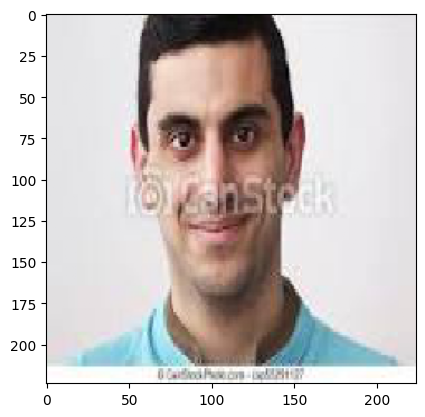

1/1 [==============================] - 0s 488ms/step
Prediction:  Middle Eastern
---------------------------


In [25]:
path = '/content/middleeastern.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
    
plt.imshow(img)
plt.show()
    
img = np.expand_dims(img, axis=0) 

prediction_proba = race_model.predict(img)

print("Prediction: ",races[np.argmax(prediction_proba)])
print("---------------------------")

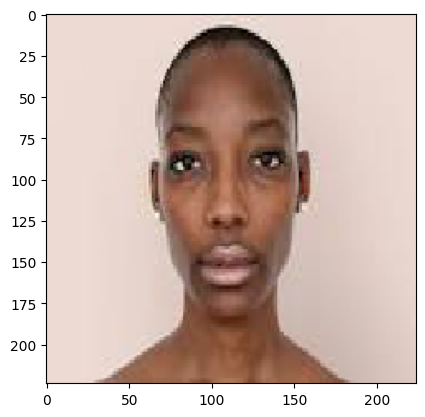

1/1 [==============================] - 0s 108ms/step
Prediction:  Black
---------------------------


In [26]:
path = '/content/blackpic.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
    
plt.imshow(img)
plt.show()
    
img = np.expand_dims(img, axis=0) 

prediction_proba = race_model.predict(img)

print("Prediction: ",races[np.argmax(prediction_proba)])
print("---------------------------")

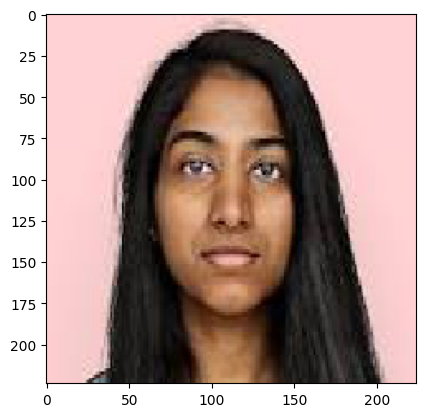

1/1 [==============================] - 0s 107ms/step
Prediction:  Middle Eastern
---------------------------


In [27]:
path = '/content/indianpic.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
    
plt.imshow(img)
plt.show()
    
img = np.expand_dims(img, axis=0) 

prediction_proba = race_model.predict(img)

print("Prediction: ",races[np.argmax(prediction_proba)])
print("---------------------------")

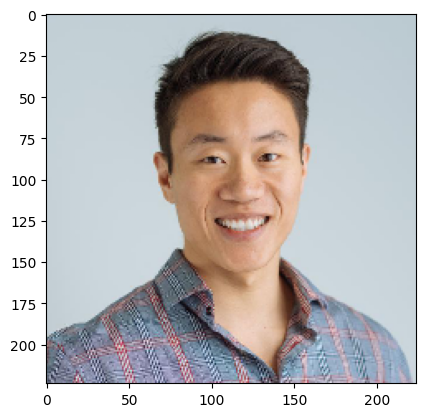

1/1 [==============================] - 0s 106ms/step
Prediction:  Asian
---------------------------


In [28]:
path = '/content/asianpic.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
    
plt.imshow(img)
plt.show()
    
img = np.expand_dims(img, axis=0) 

prediction_proba = race_model.predict(img)

print("Prediction: ",races[np.argmax(prediction_proba)])
print("---------------------------")

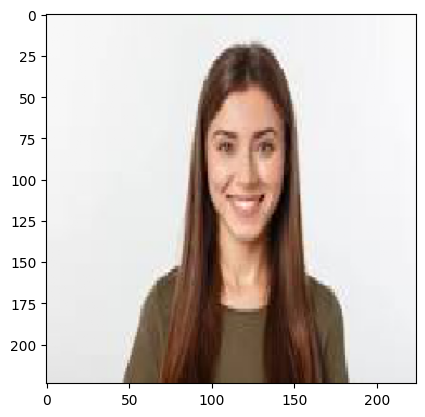

1/1 [==============================] - 0s 105ms/step
Prediction:  White
---------------------------


In [29]:
path = '/content/whitepic.jpg'
img = image.load_img(path, grayscale=False, target_size=(224, 224, 3))
img = image.img_to_array(img).reshape(1, -1)[0]
img = img.reshape(224, 224, 3)
img = img / 255
    
plt.imshow(img)
plt.show()
    
img = np.expand_dims(img, axis=0) 

prediction_proba = race_model.predict(img)

print("Prediction: ",races[np.argmax(prediction_proba)])
print("---------------------------")